# Modeling M&M Colour Distributions 

In this exercise, we will model M&M colour distributions using Bayesian inference. 

Here's the basic problem: You have a bag of M&Ms, and you want to know how many blue ones are in it. Easy, right? You open the bag, and count all the blue ones! But what if you have a [10 pound bag](https://www.mymms.com/product/bulk-mms-candy-10-lb.do?sortby=ourPicksAscend&refType=&from=fn&ecList=7&ecCategory=100601) of M&Ms? Counting them all would take you ages, wouldn't it? Or what if you had several bags. The exact number of blue M&Ms as well as the total number of M&Ms in each bag might vary! So really, what we need is a model of the *average* number of blue M&Ms per bag. We don't just need any model, but we need a *statistical* model that describes the number of blue M&Ms we would get out of a bag of M&Ms given some underlying true fraction of blue M&Ms. 

#### Imports

This exercise initially only requires `numpy`, `scipy` and `matplotlib` for plotting. Below, you might also want to use `pymc3` for sampling the hierarchical model.

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

# prettier plotting;
# comment out if seaborn is not installed
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

import numpy as np
import scipy.stats
import scipy.special

## The Binomial Likelihood

In statistics, the statistical model for how one draws observations given some underlying process is called the *likelihood*. 

In our case, we have two observations: the total number of M&Ms in a bag *N*, and the number of blue M&Ms out of that total number, $k$. 
There are only two things the M&Ms can be in our (simplified) model: blue and not-blue. It is worth noting at this point that virtually any model used to make sense of data is always a *simplification* of the true underlying process. In reality, M&Ms come in six different colours. We have *simplified* this to just two. This is fine as long as blue M&Ms are all we care about. If we suddenly also cared about green M&Ms, we'd need to make our model more complicated to account for this (more on this later)!

Back to our blue M&Ms. Every time you draw an M&M out of a bag, you get one of two outcomes: blue or not-blue. In a more statistical language, a draw of an M&M out of a bag is called a *trial*, drawing a blue M&M is called a *success* (a not-blue M&M is called a *failure*). You can do this $N$ times and then record the number of successes, $k$. 

Assuming that there is some underlying fraction $q$ of blue M&Ms being produced and put into bags, then for every time you draw an $M&M$ out of the bag, you will draw a blue one with probability $q$ and a not-blue one with probability $(1-q)$ (since these are our only two, mutually exclusive options, and all probabilities must sum up to $1$). 

$$
p(k | N, q) = {N \choose k} q^k (1-q)^(N-k) \; .
$$

Let's talk about how to read this equation. On the right side is a probability $p$, and it's the probability of getting $k$ blue M&Ms out of a bag with $N$ total M&Ms, and an underlying fraction of $q$ blue M&Ms per total. The $|$ symbol always denotes the term *given*, which implies *truths* about the world, or things we know. In this case, we *know* that we've drawn $N$ M&Ms out of the bag, and we're trying to figure out how probable it is that $k$ will be blue, given some true underlying rate $q$. Note that here, we assume that we actually *know* what the true number of blue M&Ms per bag should be, but in reality, we don't! 
Keep this in the back of your head, we'll get back to it in a little while!

On the left-hand side is the definition of the probability distribution we are interested in. The probability of drawing $k$ blue M&Ms is $q^k$ (if the draws are all independent). Then we have $N-k$ not-blue M&Ms left, and the probability of drawing those is $(1-q)^{N-k}$. The ${N choose k}$ term in the front of the expression comes from the fact that $q^k (1-q)^{N-k}$ is the probability of one *specific* sequence. For example, you could have drawn something like \[blue, blue, not-blue, blue, not-blue, not-blue, not-blue, not-blue, blue\], which is a specific sequence. But we don't really care about whether you draw a blue or not-blue first, all we care about is the total number of blue M&Ms out of the total. The first term corrects the expression for all possible permutations of sequences that could produce $k$ blue M&Ms out of $N$ total. 

This expression, as a whole, is called the *binomial distribution*, and is the likelihood we're going to use.

**Exercise**: Without looking at any M&Ms, take a guess for what a reasonable value might be for $q$. Then open your bag of M&Ms and take out 10, recording all blue ones. Calculate the probability of that number of blue M&Ms out of your set of 10 trials, given the value of $q$ you've chosen. How large is that probability? 

In [ ]:
n = 10 # number of draws out of bag
k =  # add the number of blue M&Ms you drew to this variable

q = # add the value you chose for q here

In [ ]:
def binomial_distribution(n, k, q):
    """
    Calculate the probability of $k$ successes out 
    of $n$ trials, given an underlying success rate $q$.
    
    Parameters
    ----------
    n : int
        The total number of trials
        
    k : int
        The number of successful draws out of $n$
        
    q : float, [0,1]
        The success rate
        
    Returns
    -------
    prob : float [0,1]
        The binomial probability of $k$ draws out 
        of $n$ trials
    """
    
    ## ADD YOUR FUNCTION HERE
    ## HINT: scipy.special.comb is useful for 
    ## calculating (n choose k)
    
    return prob

In [ ]:
# calculate the binomial probability 
print("Probability: " + str(binomial_distribution(n, k, q)))

For illustration, calculate the binomial probability for values of k between 0 and 10 and plot the result:

In [ ]:
ktrial = np.arange(0, 10, 1)

prob = # calculate the binomial probabilities

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(ktrial, prob, lw=2, color="black")
ax.set_xlabel(r"successes $k$ out of 10 trials")
ax.set_ylabel(r"$p(k|N,q)$")



## Calculating the Likelihood Function

There's a fundamental problem with the process above: it assumes we know $q$ (it's on the right side of the "|") and that $k$ is a random variable. But this is often not what we observe in reality! Often, we can make *observations* of the process (here: $k$ blue M&Ms out of $N$), and we care about the *parameters* of the underlying model (here: the success rate $q$). What we really want to know is not $p(k | N, q)$, but $p(q | N, k)$. It is important to realize that these two are not the same! For an illustrative example, consider a simpler case. Consider that you're given the information that your friend's dog is pregnant. What can you conclude about the dog's biological sex? Conversely, imagine you're being told the dog is female. Can you conclude with equal probability that it is pregnant? 

So, if they're not the same, do we get from $p(k | N, q)$, which we've shown we can calculate, to $p(q | N, k)$? In principle, nothing stops you from measuring your $k$ successes out of $N$ trials, and then calculating $p(k | N, q)$ for different values of $q$. However, there is a reason this is called a likelihood *function*: it is *not* a probability distribution of the parameter $q$, because $q$ is on the right-hand side of the "|" sign. It is fixed, known, assumed to be true. The binomial probability is a probability distribution in $k$, not $q$. This may sound subtle, but has huge consequences, one of them being that $p(k | N, q)$ as a function of $q$ does not integrate to 1, like a proper probability distribution.

**Exercise**: Let's try it out! Take your measured $k$ from above, and calculate $p(k | N, q)$ for different values of $q$ ranging from $0$ to $1$, then plot the resulting function. Do you think this function integrates to 1? Does it peak? Where does it peak?

In [ ]:
qtrial = # make a list of trial q's to try out

likelihood = # calculate the likelihood for qtrial

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(qtrial, likelihood, lw=2, color="black")
ax.set_xlabel(r"binomial success rate $q$")
ax.set_ylabel(r"$p(k|N,q)$")


It's not that the likelihood isn't useful: it often gives you a pretty good guess which parameter might do a good job of producing the data you've observed. But the crux is that it doesn't tell you what you want to know, because it is *not* a probability of the parameter $q$, but of the outcomes $k$. 

So can we calculate the actual probability we're interested in, $p(q | N, k)$? 

Well, this is where Bayes' theorem comes in handy. Bayes' theorem can be derived directly from some fundamental rules of probability, most importantly the *joint* probability distribution of two variables:

$$
P(A, B) = P(A|B)P(B) = P(B|A)P(A)
$$

for some generic random variables $A$ and $B$ (e.g. whether your friend's dog is female, and whether it is pregnant). What does this term say? 

Let's make a little table for the four possible outcomes (female/male, pregnant/not pregnant):

|               | pregnant (pr)   | not pregnant (n)|
| ------------- |:----------------| :---------------|
| female (f)    | 0.1             | 0.4             |
| male   (m)    | 0.0             | 0.5             |

This table expresses the *joint* probabilities of all possible outcomes. For example, the joint probability of your friend's dog being both female and pregnant is $p(\mathrm{pr}, \mathrm{f}) = 0.1$. The probability that the dog is both male and pregnant is 0. 

What does this have to do with our case above? Well, what's the joint probability of a dog being both female and not pregnant? $p(\mathrm{f}, \mathrm{n}) = 0.4$ given our table above. 

Let's ask a harder question: what's the probability of a dog being female, $p(\mathrm{f})$? To answer this question, it doesn't matter whether the dog is pregnant or not pregnant, so we just have to sum up both columns, $p(\mathrm{f}) = 0.1 + 0.4 = 0.5$. In reality, our variables are often continuous, so this often requires an integral instead of a simple sum. 

Let's ask something a little bit more complex: what's the probability that a dog is pregnant, *given* that it is female, $p(\mathrm{pr} |  \mathrm{f}) = 0.1$? Note that this is *not* the same as the *joint* probability. In the latter case, I don't know whether the dog is female, and I'm trying to calculate the probability that it is both female and pregnant. In the case we're currently looking at, I already *know* the dog is female (maybe my friend has told me), and I'm curious whether I might be able to get a puppy from my friend in the near future. So I already have one piece of information (dog is female). Because I already know this, the whole row labelled "male" no longer matters, and I only have two cases left (pregnant and not-pregnant). However, the sum of those two options is $0.5$, and I said earlier that probabilities must sum up to 1! So we'll need to re-normalize the probability to sum up to 1: 

$$
p(\mathrm{pr} |  \mathrm{f}) = \frac{p(\mathrm{pr},  \mathrm{f})}{p(\mathrm{f})} 
$$

So the probability that the dog is pregnant given that it is female is $0.1/(0.1 + 0.5) = 0.2$. 

If you move $p(\mathrm{f})$ on the other side, you get an expression for the joint probability:

$$
p(\mathrm{pr} ,  \mathrm{f}) = p(\mathrm{pr} |  \mathrm{f})p(\mathrm{f})
$$

Note that you can turn that expression around: the joint probability for your friend's dog to be both female and pregnant is also this:

$$
p(\mathrm{pr} ,  \mathrm{f}) = p(\mathrm{f} |  \mathrm{pr})p(\mathrm{pr})
$$

You can put these two together, and you've got Bayes rule as stated above (I'm going to go back to the generic variables $A$ and $B$ for this):

$$
P(A | B)  = \frac{p(B|A)P(A)}{P(B)} \, .
$$

And this is Bayes' rule! This particular theorem has many more implications than simply tallying up probabilities as we've done in the example above. In particular, there are fundamental philosophical differences between Bayesian statistics and its alternative--often also called frequentist statistics--in how one sees probabilities. In Bayesian statistics, almost anything can be a random variable, and Bayesians see probabilities as encoding our uncertainty or lack of knowledge about the world. Frequentists tend to have a more literal view of the world, and interpret probabilities as frequencies of truly random events, e.g. rolls of dice. 

## The Posterior Probability Distribution

What does all of this have to do with our M&Ms? Well, above, we have basically written down the blue-print for how to get from $p(k | N, q)$ to $p(q | N, k)$. We can stick these particular variables in our equation above:

$$
p(q | N, k) = \frac{p(k | N, q) p(q)}{p(k)} \, .
$$

In theory, this tells us exactly how to calculate the probability of the *parameter* $q$ that we're looking for, given that we've drawn $k$ blue M&Ms out of a bag with $N$ M&Ms total. $p(q | N, k)$ is generally called the *posterior probability distribution*. We're not done, though. In particular, we've written down the equation, and we know how to calculate $p(k | N, q)$, but what are $p(q)$ and $p(x)$? 

I've made a big production above that $p(k | N, q)$ isn't normalized, and that this is important. The product $p(k | N, q) p(q)$ is still not normalized, but $p(q | N, k)$, so $p(k)$ is effectively a normalizing constant:

$$
p(k) = \int{p(k | N, q) p(q) dq} 
$$

such that the whole probability distribution integrates to 1. In practice, this is the probability of observing the data $k$ times $p(q)$, integrated over all possible values of $q$. This is also called the *marginal likelihood* or *evidence*. While this no longer depends on $q$, this doesn't mean it has no assumptions. For example, we've assumed above that our data can be modelled by a binomial distribution. This may not be true, and we should probably have included another variable $B$ on the given side of our probabilities to indicate there's an underlying assumption there, e.g. $p(k | B)$. Notice that this looks a lot like a likelihood? Well it is, but it is now the likelihood of observing the data given the generalized assumption that the data were drawn from any binomial distribution. If we had another model for the data, say a Poisson distribution, we could also calculate $p(k | P)$ (where $P$ stands for the Poisson model) and compare the two. This is why the marginal likelihood is often used for *model comparison*.

In this tutorial, we're not going to worry about comparing different kinds of (statistical) models, but instead worry about estimating the parameter $q$. For this the normalizing constant $p(k)$ is exactly that, a constant, the same for all possible values of $q$. if we're only interested in the relative probabilities of a specific $q_0$ to a different $q_1$, we can ignore that constant and write

$$
p(q | N, k) \propto p(k | N, q) p(q) \, .
$$

which is going to make our lives a whole lot easier, because $p(k)$ is often very hard to compute in practice

## Priors

The one thing we *haven't* talked about yet is $p(q)$. You'll notice that this is a probability distribution of $q$ only, without the data playing a role. This is often called the **prior probability distribution**, and it encodes whatever prior knowledge you might have about this parameter before you've looked at the data. For example, you might know that there are six colours in a package of M&M, so you might conclude that it's extremely unlikely that $q=1$, i.e. that there are only blue M&Ms in your bag. 

**Exercise**: Think about what you know about M&Ms. Do you have any prior knowledge about how many M&Ms there might be in a bag? Think about the number you picked for $q$ when you calculated the binomial probability earlier. Why did you pick that value? 

**Careful**: Of course, you've already seen the data! This is generally not how you go about things, so you're going to have to pretend you haven't (or take a new bag :) ). 

Note that I've said earlier that $p(q)$ is a probability *distribution*, so it has to be more than one value. It has to encode your knowledge about $q$ for all possible values of $q$, which can in principle be anywhere in the range between 0 and 1. One simple choice is to make all possible values of $q$ equally likely, but we've already said earlier that this is probably not a good assumption, because we don't think our bag will be all blue M&Ms. In general, this kind of prior is called a *uniform distribution*, and while it may seem like the choice that is least affected by what you know, this is in practice *not* always true! We won't go into the details here of why or when this is the case, but be mindful that this is something you might have to think about in practice. 
There's another thing to be aware of with the uniform distribution: it makes a very, very strong assumption about what values $q$ is allowed to take. If we set the prior to be uniform between $0$ and $1$, this would be an okay choice, because these are all the values $q$ can take in practice. However, imagine you picked a prior for $q$ between 0.5 and 1. You have just assumed that $q$ can *never, ever* be lower than 0.5, *no matter* what your data tell you! This is a really strong assumption to make, and you'd better be really sure that it's a reasonable one! 
In practice, it's often better to choose distributions that fall off sharply, but retain some (small, but not impossible) prior probability in all theoretically allowed values, unless you're absolutely confident that these values cannot be true.

### Conjugate Priors

So in principle, you could choose any distribution for $q$. Maybe you eat a package of M&Ms every day, so you have a pretty good feeling for $q$. You could choose a normal distribution around your estimated value of $q = \mu$, assign some narrow width $\sigma$ to the distribution, and you'd have a perfectly good prior: $p(k | \mu, \sigma) \sim \mathcal{N}(\mu, \sigma)$. Note that in this case $\mu$ and $\sigma$ define the shape of the prior distribution, and are called **hyperparameters**. They're given (i.e we've set them in advance), so they're on the right-hand side of the "|".

One issue with this is that you don't just want to calculate $p(k | \mu, \sigma)$, but $\propto p(k | N, q) p(q | \mu, \sigma)$, and there's no guarantee that the latter will be an analytically solveable equation for any choice of $p(k)$. However, for most likelihood functions, there do exist functions that you can use as priors that will lead to analytical expressions for the posterior. These are called **conjugate priors** and are a good choice when you don't have much prior information about your parameter $q$ and/or the conjugate prior matches the shape of what you *do* know about $q$. 

The conjugate prior for the binomial distribution is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). This distribution has two parameters, $\alpha$ and $\beta$ and is defined as 

$$
p(x | \alpha ,\beta ) =\mathrm{constant} \cdot x^{\alpha -1}(1-x)^{\beta -1} \; .
$$

It can take many different shapes.

**Exercise**: Calculate the prior probability density for different values of $\alpha$ and $\beta$, and plot the result. How does the shape of the distribution change for different values of the two parameters? Which combination of parameters makes a good prior for $q$ in your opinion?

**Hint**: You don't have to write your own version of the beta-distribution. The `scipy.stats` package contains a large list of distributions ready-made for you, including the [beta distribution](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.beta.html).

In [ ]:
qtrial = np.linspace(0, 1, 500) # trial values of q

alpha = # set the value for alpha
beta = # set the value for beta

# set up the probability distribution
beta_dist = scipy.stats.beta(alpha, beta)

# calculate the probability density for qtrial
beta_pdf = beta_dist.pdf(qtrial)


In [ ]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(qtrial, beta_pdf, lw=2, color="black")
ax.set_label(r"Parameter $q$")
ax.set_ylabel(r"Prior distribution $p(q)$")
ax.set_title("beta-distribution prior")

Chosen values for the hyper-parameters
* $\alpha = $
* $\beta = $

**Exercise**: Share your results with the class and discuss. Did you all pick similar values? Are your choices significantly different to those of others? How do your assumptions differ?

It is important to notice that there is no one correct choice for a prior, because by its very definition, it depends on your *prior knowledge* about the problem you're trying to solve! Someone who has eaten M&Ms regularly since childhood might have a different knowledge about the fraction of blue M&Ms in a bag than someone who has never had any before today! This may at first seem like a disadvantage, because making different assumptions about $q$ seems like it's not very objective, and science is supposed to be objective, right?

Well, it's not that easy, because the idea that science is absolutely objective is itself a fallacy. Whenever we write down a model for observations, we *always* make assumptions (as for example, we pointed out explicitly above with the binomial model), and those assumptions can differ from researcher to researcher and change over time. 
A lack of explicit prior probability distribution does *not* equal a lack of assumptions. The assumptions might not be explicit, but they exist. An advantage of Bayesian statistics is that it requires you to state your assumptions explicitly, which means the can be examined and discussed like anything else we do. 

### Calculating the Posterior

Okay, now we've got all of our components in place, which means we can calculate our posterior probability density. And there are some good news: because we've chosen a conjugate prior for our likelihood, the posterior is analytical. In fact, the posterior to a binomial likelihood and a beta-prior is also a beta-distribution,

$$
p(q | k, N) = \mathrm{Beta}(\alpha+k,\beta+N-k)
$$

**Exercise**: Calculate both the prior for your chosen values of $\alpha$ and $\beta$ and plot them in the same figure. How has the posterior changed from your prior? 

In [ ]:
### First, repeating this from the prior above

qtrial = np.linspace(0, 1, 500) # trial values of q

alpha = # set the final value for alpha
beta = # set the final value for beta

# set up the probability distribution
beta_prior = scipy.stats.beta(alpha, beta)

# calculate the probability density for qtrial
beta_prior_pdf = beta_prior.pdf(qtrial)

### Now let's calculate the posterior

a_post = # alpha + k
b_post = # beta + N - k

# set up the probability distribution 
beta_posterior = scipy.stats.beta(a_post, b_post)

# calculate PDF
beta_post_pdf = beta_posterior.pdf(qtrial)


In [ ]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(qtrial, beta_prior_pdf, lw=2, color="black", label="prior")
ax.plot(qtrial, beta_post_pdf, lw=2, color="black", 
        linestyle="dashed", label="posterior")

ax.set_label(r"Parameter $q$")
ax.set_ylabel(r"Prior distribution $p(q)$")
ax.set_title("beta-distribution prior")

ax.legend()
plt.tight_layout()

**Exercise**: Imagine that you'd chosen values for $\alpha$ and $\beta$ that are very unlikely to be true (e.g. a distribution that rises towards $q=1$. Repeat the comparison between prior and posterior above with these unlikely values. Does the different prior affect the results? How? 

**Important Note**: The above exercise, i.e. to change the prior and go back to re-calculate the posterior, is an academic exercise only! In practice, you **cannot** go back and change your prior once you've looked at your data and calculated your posterior! The prior *only* encodes knowledge about $q$ *before* you looked at the data. If you look at the data, then change your prior and calculate the posterior again, you've effectively used the data twice! In practice, this will lead you to be unreasonably overconfident in your results. Once you've looked at your data, your only real solution is to gather more data and use the posterior from your current analysis as a prior for the future (more M&Ms! Oh No! :) ). 


### Adding More Information

These are the results for one package of M&Ms. Can we actually make this better? Yes, because you have classmates all around you who also have counted blue M&Ms! 

**Exercise**: Tally up the total number of blue M&Ms counted by everyone in the class, and the total number of M&Ms from everyone. Then use the new numbers for $k$ and $N$ to calculate and plot the posterior as well as the prior.

## Markov Chain Monte Carlo

### Or: What to do when your posterior is not analytical.

In practice, you will often end up in situations where conjugate priors are not a good choice, and your posterior will not be analytical. What you do in this case depends on what you want to know. For example, you might only be interested in the *most probable* value of $q$. In this case, optimization algorithms are often a good choice. This is sometimes also your only option for example if the likelihood function is very expensive to calculate.

However, often the posterior probability can be complex, and trying to find the most probable value isn't good enough. Imagine you had a probability distribution with two roughly equally tall peaks, at 0.2 and 0.8, with a valley of low probability in between. An optimization algorithm will always end up in one of the two peaks, and will give you a single value, but you might never find out about the other peak!

So what can we do? If you need to map out the probability distribution as a whole, there are several approaches. The simplest and straightforward is to make a grid in $q$, e.g. of a 100 points, and calculate $p(q | N, k)$ for each of those points, and then plot the result. Easy, right? This works well for problems with very low dimensions, like ours, where we only have a single parameter. What if you don't have a single parameter, but 50? You now need to sample 100 points in each of those 50 dimensions, meaning you need $100^{50}$ points. If your posterior takes a microsecond to calculate, you'll still need longer than the age of the universe to calculate all of those points! This is clearly impossible.

So can we do something smarter than a grid? Yes! In fact, we can find clever ways to jump through parameter space in such a way that we'll evaluate our posterior often in regions where the posterior is large, and less often in regions where the posterior is low. There are a whole range of different algorithms that can do this, but **Markov Chain Monte Carlo (MCMC)** is the most common and most popular one. 


**TODO: FINISH MCMC PART**

## A slightly more complex model ...

Let's make our problem above more complicated. What if we're not just interested in the blue M&Ms, but want to know the distribution of all six colour? Well, where the binomial distribution only considered *success* and *failure*, there is a generalization to this distribution that considers *multiple categorical outcomes* (in our case six colours). In this case, we don't have a single $k$ given $N$ trials, but multiple $\mathbf{k} = \{k_1, k_2, ..., k_l\}$ for $l$ possible outcomes. In our case, $l=6$, and each $k_i$ stands for a single colour (e.g. $k_0 = \mathrm{blue}$,$k_1 = \mathrm{green}$, ...). Similarly, we now have a vector $\mathbf{q} = \{q_1, q_2, ..., q_l\}$ for the underlying true fraction of each colour. 

This generalization is the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), defined as:

$$
    p(\mathbf{k} | \mathbf{q}, N)= 
\begin{cases}
    \frac{N!}{k_1! k_2! ... k_l!}q_1^{k_1}q_2^{k_2} ... q_l^{k_l},& \text{when } \sum_{i=1}^{l}k_i=N \\
    0,              & \text{otherwise}
\end{cases}
$$

Our measurements are now the number of M&Ms for each colour. Our parameters are the underlying fractions $q_i$ for each colour. We now have a six-dimensional measurement, and six parameters for our new model.

**Exercise**: Define a six-element vector with your prior expectations for what you think the different $q_i$ should be. Do you think all colours are represented equally?


In [ ]:
q_blue = # fraction of blue M&Ms
q_green = # fraction of green M&Ms
q_red = # fraction of red M&Ms
q_yellow = # fraction of yellow M&Ms
q_orange = # fraction of orange M&Ms
q_brown = # fraction of brown M&Ms

q_all = np.array([q_blue, q_green, q_red, 
                  q_yellow, q_orange, q_brown])

Now tally up all the colours in your package of M&Ms and write down the result:

In [ ]:
k_blue = # blue M&Ms
k_green = # green M&Ms
k_red = # red M&Ms
k_yellow = # yellow M&Ms
k_orange = # orange M&Ms
k_brown = # brown M&Ms

# all measurements together
k_all = np.array([k_blue, k_green, k_red, 
                  k_yellow, k_orange, k_brown])

n_total = # total number of M&Ms in package

Let's calculate the multinomial probability for these measurements:

In [ ]:
# define the distribution
mult = scipy.stats.multinomial(n=n_total, p=q_all)

# calculate the probability for our measurements:
print("multinomial probability: " + str(mult.pdf(k_all)))

Ideally, we'd like to calculate a posterior probability for this, too, so we'll need to define a prior for $\mathbf{q}$. The conjugate prior for the multinomial distribution is a [*Dirichlet distribution*](https://en.wikipedia.org/wiki/Dirichlet_distribution), the multivariate generalization of the beta-ditribution. The Dirichlet distribution appears fairly often in problems with categorical variables and is very useful to know. A nice conceptual introduction can be found [here](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/).

For our 6 different categories (colours), the Dirichlet distribution has six parameters called *concentration parameters*, $\mathbf{\alpha} = \{\alpha_1, \alpha_2, ..., \alpha_l\} \, , \, \alpha_i > 0$. 
Note that it is only defined on the interval $(0,1)$, and also only in the region where $\sum_{i=1}^{l}q_i = 1$ (remember: our $q_i$ are relative fractions of colour $i$, and if we take all fractions for all colours, they must make up all of our M&Ms).

Of course, `scipy.stats` also has an implementation of the [Dirichlet distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html#scipy.stats.dirichlet).

In practice, the PDF of the Dirichlet distribution is a bit tricky to plot, because of the way that your trial values of $q_i$ need to sum up to $1$. You can look at [this illustration](https://en.wikipedia.org/wiki/Dirichlet_distribution#/media/File:Dirichlet-3d-panel.png) to see how the PDF changes for different values of $\alpha$. 

**Exercise**: Let's plot the PDF of a Dirichlet distribution with two categories, i.e. two concentration parameters $\alpha_i$, and plot the results. Repeat for different values and combinations of $\alpha_1$ and $\alpha_2$. How does the distribution change? What do you think are reasonable values for the different values of $\alpha_i$?

In [84]:
alpha1 = # add your guess for alpha1
alpha2 = # add your guess for alpha2
alpha = [alpha1, alpha2] # add

# define the dirichlet distribution
dirichlet = scipy.stats.dirichlet(alpha=alpha)


In [85]:
x1 = np.linspace(0, 1, 1000)
x2 = 1.0 - x1

In [86]:
pdf = dirichlet.pdf([x1, x2])

<IPython.core.display.Javascript object>


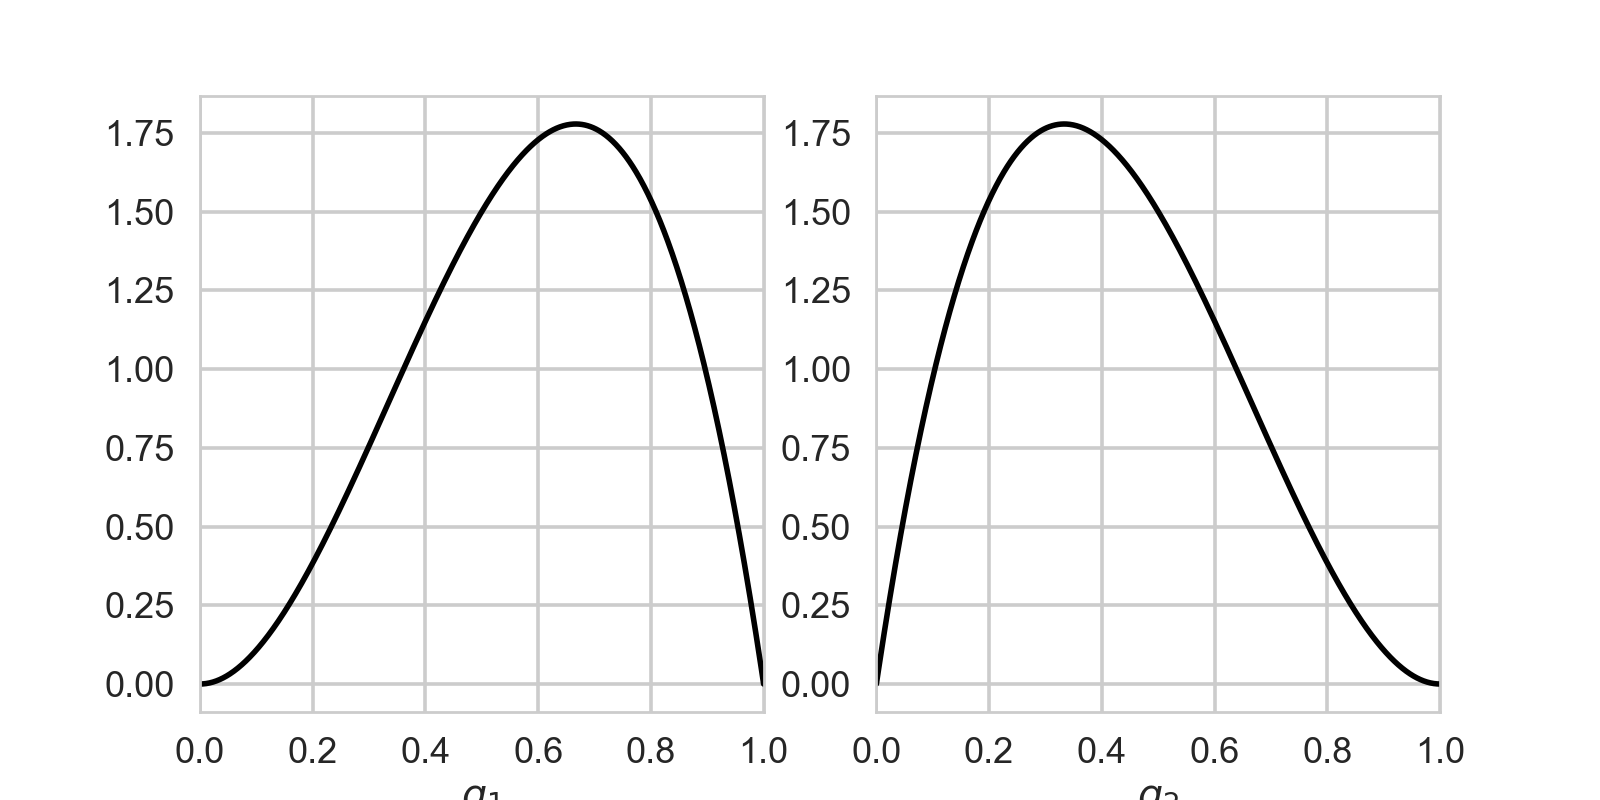

Text(0.5,0,'$q_2$')

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(x1, pdf, lw=2, color="black")
ax1.set_xlim(0,1)
ax1.set_xlabel(r"$q_1$")

ax2.plot(x2, pdf, lw=2, color="black")
ax2.set_xlim(0,1)
ax2.set_xlabel(r"$q_2$")

Now we can set up our posterior inference! 

First, set your concentration parameters for each of the values of $\alpha_i$:

In [48]:
alpha_blue = # blue M&Ms concentration parameter
alpha_green = # green M&Ms concentration parameter
alpha_red = # red M&Ms concentration parameter
alpha_yellow = # yellow M&Ms concentration parameter
alpha_orange = # orange M&Ms concentration parameter
alpha_brown = # brown M&Ms concentration parameter

# all parameters together
alpha_all = np.array([alpha_blue, alpha_green, alpha_red, 
                      alpha_yellow, alpha_orange, alpha_brown])

SyntaxError: invalid syntax (<ipython-input-48-ba80751f6dcd>, line 1)

The posterior distribution of a multinomial likelihood with a Dirichlet prior is also a Dirichlet distribution, with concentration parameter $\mathbf{\alpha}_{\mathrm{posterior}} = \mathbf{\alpha}_{\mathrm{prior}} + \mathbf{k}$:

In [89]:
alpha_post = alpha_all + k_all

dir_post = scipy.stats.dirichlet(alpha=alpha_post)

For a 6-dimensional distribution, it's much harder to think about where the Dirichlet distribution is even defined (it should lie on a 5-dimensional volume in six dimensions for which $\sum_{i=1}^{l}q_i = 1$. Instead of calculating the posterior for a grid of values for $q_i$, we're just going to draw samples directly from the posterior distribution and then plot them:

In [91]:
# generate random samples from the posterior
post_rvs = dir_post.rvs(size=1000000)

<IPython.core.display.Javascript object>


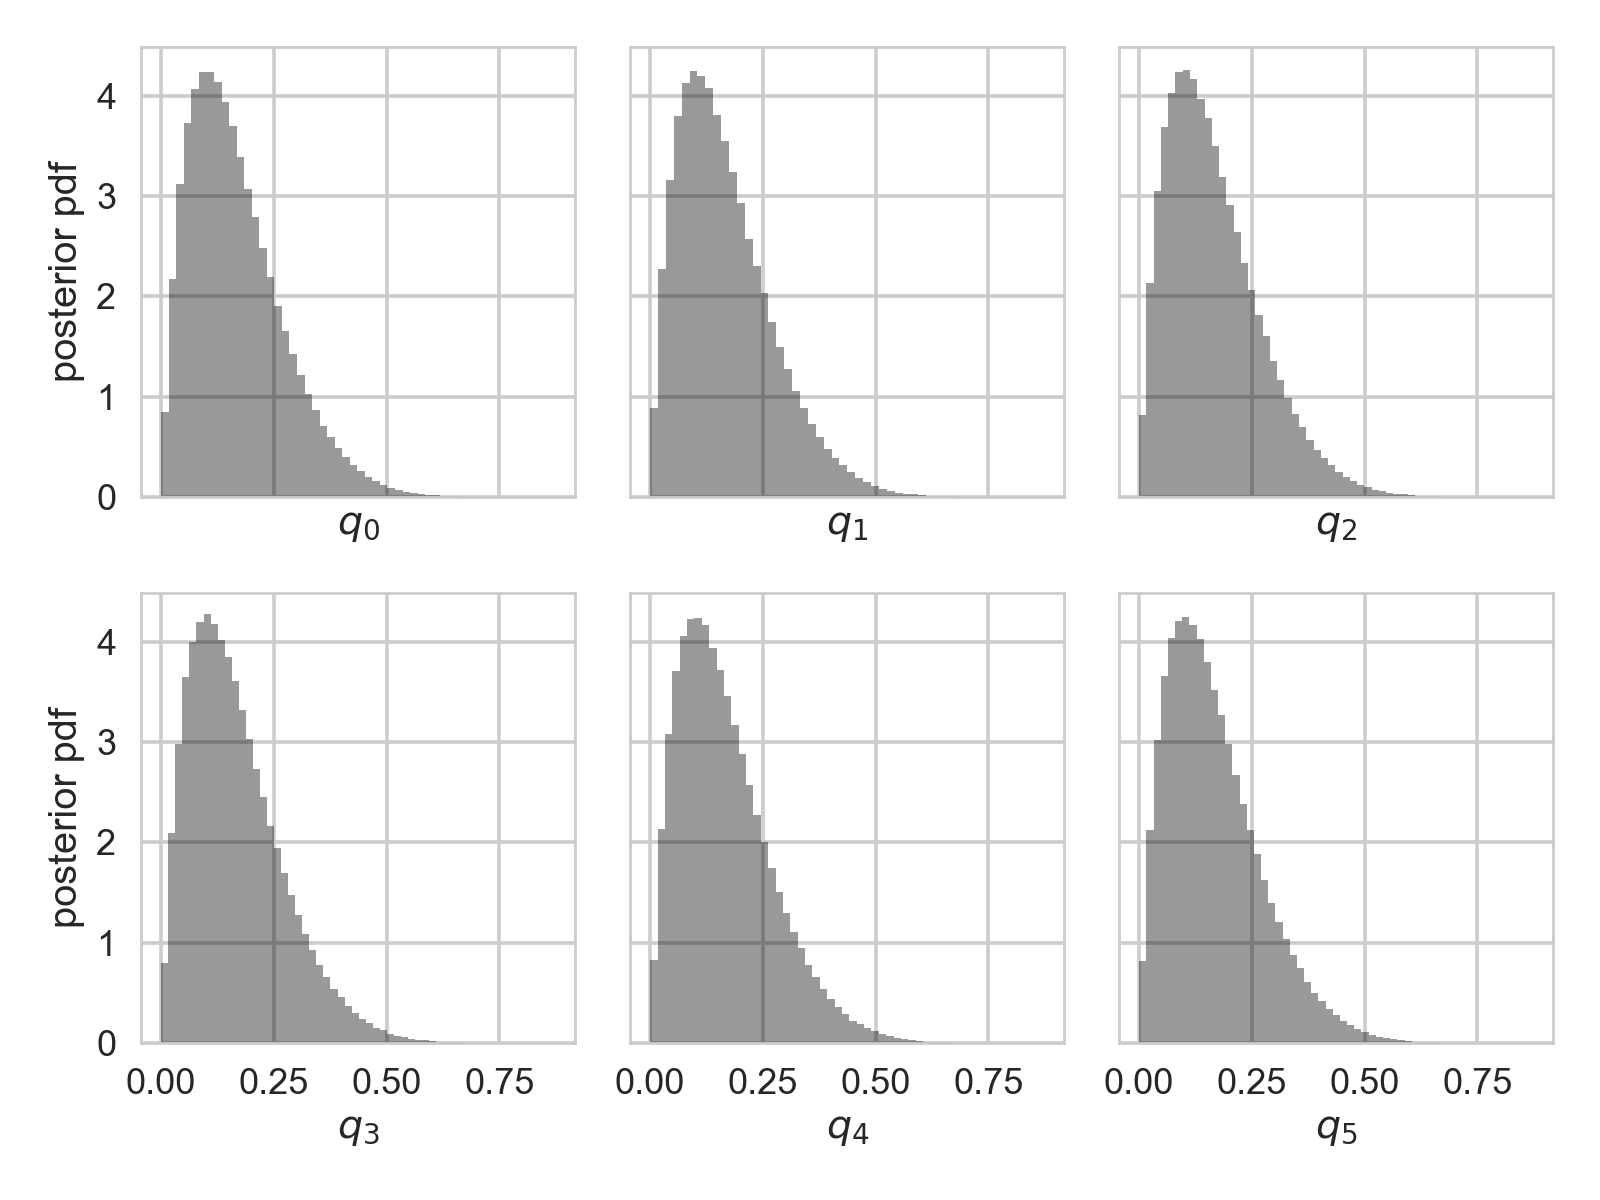

In [99]:
# plot marginal distributions
fig, axes = plt.subplots(2, 3, figsize=(8,6), sharex=True, sharey=True)

# flatten the array of axis objects
axes = np.hstack(axes)

# we have six colours, so we're going to loop over each
for i in range(6):
    axes[i].hist(post_rvs[:,i], bins=50, histtype="stepfilled", 
                 color="black", alpha=0.4, density=True)
    axes[i].set_xlabel(r"$q_%i$"%i)
    # set the y-axis labels only on the left-most plots
    if i == 0 or i == 3:
        axes[i].set_ylabel("posterior pdf")

# automatically improve spacings between subplots
plt.tight_layout()

## Bayesian Hierarchical Modelling

Now that we can model all colours at once, it's time to let you in on a little secret: M&Ms in the US are produced by two different factories, one in Tennesse and one in New Jersey. The interesting part is that they produce different distributions of colours! Why? Nobody is really sure (except probably the Mars Company, which makes M&Ms).

So each of you has their own package of M&Ms, and you've all recorded the number of different colours and calculated the posterior distribution for your parameters, but now you'd like to figure out which factory your M&Ms came from. However, while you know that the two different factories make different colour distributions, you don't know the distributions each makes, and you also don't know which factory your particular package came from! This seems like an insurmountable lack of knowledge, but fear not! Through the power of sharing information between you, you'll be able to figure all of that out.

In the previous examples, you pooled your information for the entire class in order to improve your posterior. However, we glossed over the fact that your packages did not come from the same factory! How can we take better account of that fact? Through Bayesian hierarchical modelling! 

In the previous models you've built you had a prior distribution on your parameters, and the hyperparameters of these prior distribution were fixed. They were numbers you chose based on your prior information and intuition of the problem. In a hierarchical model, the parameters describing the prior are *not* fixed, but something that we *infer* along with the parameters of the colour distributions. Instead of describing prior knowledge, they describe the *population* of data sets, in our case the *population* of bags. 

We go from a model like this

$$
p(q | \{\mathbf{k}_b\}_{b=1}^{B}) \propto  p(q | \alpha) \prod_{b=1}^{B} p(\mathbf{k}_b | q)
$$

where $\alpha$ were fixed hyperparameters, to adding one more layer of parameters:

$$
p(\{q\}_{b=1}^{B}, \alpha | \{\mathbf{k}_b\}_{b=1}^{B}) \propto p(\alpha | \beta) \prod_{b=1}^{B}p(\mathbf{k}_b | q_b) p(q_b | \alpha)
$$

where now $\theta$ isn't shared anymore among the individual data sets (i.e. bags of M&Ms), and we're inferring the population parameters $\alpha$ along with the $\theta$ for each bag of M&Ms.

In our case, the difference to our previous model is that we now have *two* colour distributions--one for each factory--and that each bag comes from one of those factories based on some unknown mixture distribution.

How can we write that down? Well, we are going to introduce a new variable $\theta$ to describe the probability distribution of a bag of M&Ms coming from the New Jersey factory as opposed to the Tennessee factory. And we're also going to give each bag a new variable $z_b$ drawn from the discrete distribution for $\theta$ which describes the assignment of each individual bag to come from a certain factory. There we have our hierarchy in the model: Each bag has a probability distribution of coming from the NJ or TN factory, and together, these probabilities are drawn from a prior describing the overall proportions of *all* bags coming from either factory. We're going to infer both together.

The rest of the model doesn't really change, except that we need a prior for $\theta$. Much like our initial example, where we only had two possible outcomes, we only have two factories, so our prior in this case is also a beta-distribution.